# Voting percentage and parties relationships

In [101]:
import ssl
import pandas as pd
import numpy as np
import seaborn as sns
import math
from matplotlib import pyplot as plt
import random
import statistics 
import plotly.express as px
import plotly.offline as pyo
import scipy as sc
import warnings
warnings.filterwarnings("ignore")


## Section 1

In [102]:
df1 = pd.read_csv('https://drive.google.com/u/3/uc?id=1oWHFIrfY-wfUu3aaquK-fcYDDGW8gws3&export=download')
df1.loc['total'] = df1.sum()
parties_names = {'מחל':'ליכוד','פה':'יש עתיד','ט':'ציונות דתית','כן':'כחול לבן','שס':'שס','ג':'יהדות התורה','ל':'ישראל ביתנו','עם':'רעם','ום':'חדש-תעל','אמת':'העבודה','מרצ': 'מרצ','ד':'בלד', 'ב':'הבית היהודי'}

real_freq = {key: [] for key in parties} # Calculating real_frequencies with 'מעטפות חיצוניות' as was asked for in the Moodle forum

for party in real_freq: # Calculating real freq for later questions with 'מעטפות חיצוניות'
  real_freq[party] = df1[party]['total'] / df1['כשרים']['total']
temp_sum = sum(real_freq.values())
real_freq = {party: real_freq[party]/temp_sum for party in real_freq} # Normailizing sum of real frequncies in 13 biggest parties to be 1

df1 = df1.drop('total')

for i in range(len(df1)):
  if df1['שם ישוב'][i] == 'מעטפות חיצוניות':
    df1 = df1.drop(i)
df1.index = range(0, len(df1))
df1.loc['total'] = df1.sum()
all_parties = list({key: [] for key in df1.columns[11:]}.keys())
parties = pd.DataFrame(df1.iloc[-1, 11:].sort_values()[-13:]).index.values
alphabet_parties = [party for party in all_parties if party in parties]

def reduce_parties(df): # Helper function to remove unnecessary data
  for party in all_parties:
    if party not in parties and party in df.columns:
        df = df.drop(party, axis = 1)
  return df


In [103]:
def estimating_support(df, method):
  df = reduce_parties(df)

  df1 = df # df1 for matrix opertaion in beta 
  for col in df.columns:
    if col not in parties:
      df1 = df1.drop(col, axis = 1)


  parties_freq = {key: [] for key in parties}
  possible_voters = df['בזב'].iloc[-1]
  if method == 'alpha':
      alpha_inverse = list(df['בזב'] / df['כשרים'])[0:len(df)-1]  # Real vote percentage per ballot
      for party in parties_freq:
        parties_freq[party] = sum([df[party][i] * alpha_inverse[i] for i in range(0, len(alpha_inverse))]) / possible_voters
      temp_sum = sum(parties_freq.values())
      parties_freq = {party: parties_freq[party]/temp_sum for party in parties_freq} # Normailizing sum of q_j to be 1
  else:
      df_matrix = (df1.iloc[0:len(df)-1, 0:]).to_numpy()
      beta_inverse = np.dot((np.dot((np.linalg.inv(np.dot(df_matrix.transpose(), df_matrix))),  df_matrix.transpose())) , list(df['בזב'][0:len(df)-1]))
      beta_inverse_dict = {key: [] for key in alphabet_parties}
      i = 0
      for party in beta_inverse_dict:
        beta_inverse_dict[party] = beta_inverse[i]
        parties_freq[party] = df[party]['total'] * beta_inverse_dict[party]  / possible_voters
        i+= 1
      temp_sum = sum(parties_freq.values())
      parties_freq = {party: parties_freq[party]/temp_sum for party in parties_freq} # Normailizing sum of q_j to be 1

  return parties_freq

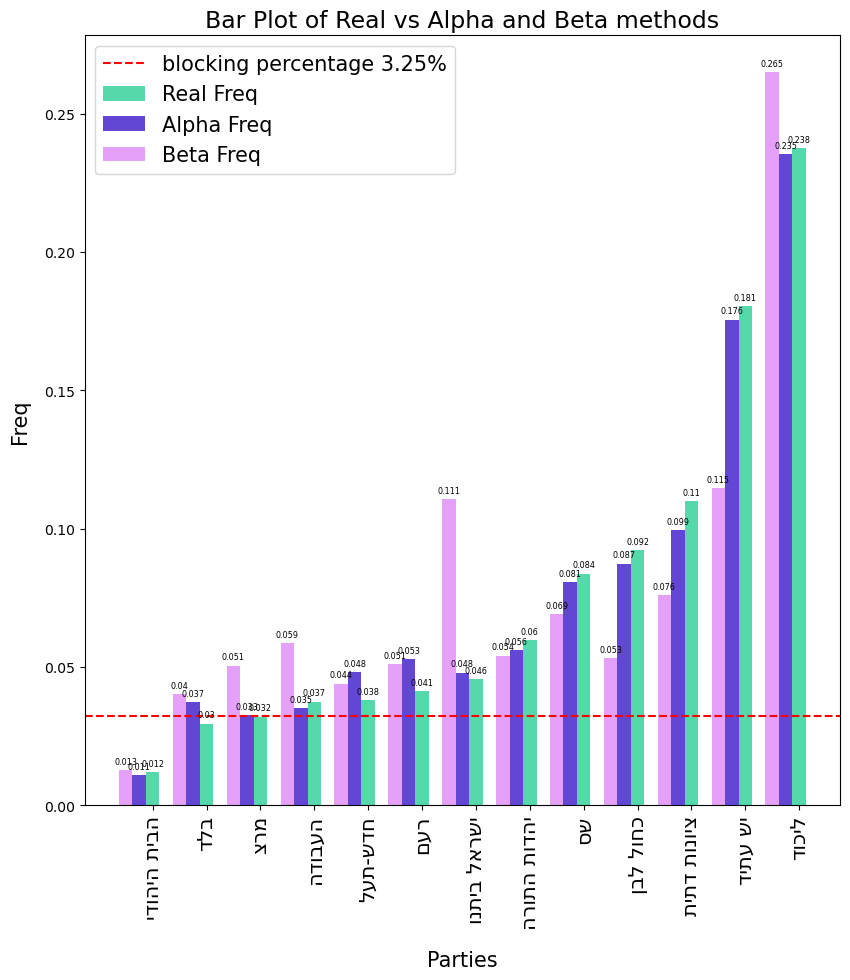

In [104]:

alpha_freq, beta_freq = estimating_support(df1, 'alpha'), estimating_support(df1, 'beta')

parties_reverse = [party[::-1] for party in list(parties_names.values())[::-1]]

width = 0.25
X = np.arange(len(real_freq))
ax = plt.subplot(111)
first = ax.bar(X  , real_freq.values(), width, color='#55d9ab', align='center')
second = ax.bar(X - width, alpha_freq.values(), width, color='#6246d4', align='center')
third = ax.bar(X - 2*width , beta_freq.values(), width, color='#e5a0fa', align='center')
plt.axhline(0.0325, linestyle = '--', color = 'red')
ax.legend(('blocking percentage 3.25%','Real Freq','Alpha Freq', 'Beta Freq'), fontsize = 15)
plt.xticks(X, parties_reverse, fontsize = 15, rotation = 90)
plt.xlabel('Parties', labelpad = 15, fontsize = 15)
plt.ylabel('Freq', labelpad = 10, fontsize = 15)

plt.title("Bar Plot of Real vs Alpha and Beta methods", fontsize=17)
plt.rcParams["figure.figsize"] = [len(real_freq) * 3 * width, 10]
temp1 = [round(item, 3) for item in real_freq.values()]
temp2 = [round(item, 3) for item in alpha_freq.values()]
temp3 = [round(item, 3) for item in beta_freq.values()]
ax.bar_label(first,labels = temp1 ,padding=3, fontsize=5.8)
ax.bar_label(second,labels = temp2 ,padding=3, fontsize=5.8)
ax.bar_label(third,labels = temp3 ,padding=3, fontsize=5.8)
plt.show()


In [105]:
pd.DataFrame([real_freq, alpha_freq, beta_freq], index = ['real_freq', 'alpa_freq', 'beta_freq']).transpose()

,real_freq,alpa_freq,beta_freq
ב,0.012096,0.011032,0.012746
ד,0.029534,0.037450,0.040276
מרצ,0.032128,0.032520,0.050533
אמת,0.037497,0.035287,0.058578
ום,0.038081,0.048146,0.044000
עם,0.041344,0.052820,0.050960
ל,0.045528,0.047991,0.110646
ג,0.059698,0.056159,0.054116
שס,0.083725,0.080791,0.069178
כן,0.092144,0.087387,0.053173


Looking at the graph and table above, we can see that 'מרצ' and 'בלד' parties would benfit from both alpha and beta estimators, especially with the beta estimator. Both parties would pass the blocking percenage with both estimators.

All other parties which passed the blocking percenage would still pass it with both estimators as well.


### Section 2

In [106]:
def binomial_simulation(potential_voters, support_frequencies): # Using random.binomial func to calculate
  result_matrix = pd.DataFrame(np.random.binomial(potential_voters, support_frequencies))
  result_matrix.columns = alphabet_parties
  return result_matrix

### Section 3

In [107]:
potential_voters = reduce_parties(df1.iloc[0:len(df1) - 1, 11:])
for party in parties:
  potential_voters[party] = [round(item) for item in np.array(df1[party][0:len(potential_voters)]) * np.array(df1['בזב'][0:len(potential_voters)])
                             /np.array(df1['כשרים'][0:len(potential_voters)]) ] # Calculating poteinal voters by given formula and then rounding it


support_frequencies_alpha =  reduce_parties(df1.iloc[0:len(df1) - 1, 11:])
for i in range(len(support_frequencies_alpha)):
  support_frequencies_alpha.iloc[i, 0:] = [df1['כשרים'][i] / df1['בזב'][i]] * len(support_frequencies_alpha.columns) #Alpha freq by given formula


support_frequencies_beta = reduce_parties(df1.iloc[0:len(df1) - 1, 11:])
frequncies = np.arange(0.2, 0.8, 0.05) # Creating Beta interval
i = 0
for party in parties: # Assiging Beta freq according to party size(biggest party gets maximal Beta and so on in declining order)
  support_frequencies_beta[party] = [frequncies[i]] *  len(support_frequencies_beta)
  i += 1

In [108]:
global method_1_estimator_1  
method_1_estimator_1= {key: [] for key in parties[::-1]}
global method_1_estimator_2  
method_1_estimator_2 = {key: [] for key in parties[::-1]}
global method_2_estimator_1 
method_2_estimator_1 = {key: [] for key in parties[::-1]}
global method_2_estimator_2  
method_2_estimator_2  = {key: [] for key in parties[::-1]}


for i in range(0, 50):
  temp1 = binomial_simulation(potential_voters, support_frequencies_alpha)
  temp1 = temp1.assign(בזב = df1['בזב'][0:len(df1)-1], כשרים = df1['כשרים'][0:len(df1)-1])
  temp1.loc['total'] = temp1.sum()

  temp3  = binomial_simulation(potential_voters, support_frequencies_beta)
  temp3 = temp3.assign(בזב = df1['בזב'][0:len(df1)-1], כשרים = df1['כשרים'][0:len(df1)-1])
  temp3.loc['total'] = temp3.sum()

  method_alpha_estimator_alpha_temp = estimating_support(temp1, 'alpha')
  method_alpha_estimator_beta_temp = estimating_support(temp3, 'alpha')
  method_beta_estimator_alpha_temp = estimating_support(temp1, 'beta')
  method_beta_estimator_beta_temp = estimating_support(temp3, 'beta')
  
  for party in parties:
    method_1_estimator_1[party].append(method_alpha_estimator_alpha_temp[party])
    method_1_estimator_2[party].append(method_alpha_estimator_beta_temp[party])
    method_2_estimator_1[party].append(method_beta_estimator_alpha_temp[party])
    method_2_estimator_2[party].append(method_beta_estimator_beta_temp[party])



In [109]:
j=1
helper = [1, 1, 2, 2] 
for i in helper:
  if j == 3:
    j = 1
  var_dict = {} # Dictionary for Variance estimators
  bias_dict = {} # Dictionary for Vias estimators
  mse_dict = {} # Dictionary for MSE estimators
  expected_value_dict = {}
  for party in parties: # Using formulas to calculate 
    expected_value_dict[parties_names[party]] = statistics.mean(globals()[f'method_{i}_estimator_{j}'][party])
    bias_dict[parties_names[party]] = expected_value_dict[parties_names[party]] - real_freq[party]
    var_dict[parties_names[party]] = statistics.variance(globals()[f'method_{i}_estimator_{j}'][party]) 
    mse_dict[parties_names[party]] = (var_dict[parties_names[party]] + (bias_dict[parties_names[party]]**2))
  globals()[f'method_{i}_estimator_{j}_df'] = pd.DataFrame([expected_value_dict, var_dict,bias_dict,mse_dict], # Data frame of the 3 dictionaries
                                                            index = ["Expected Value", "VAR", "Bias", "MSE"]).transpose()
  j += 1


In [110]:
method_1_estimator_1_df

,Expected Value,VAR,Bias,MSE
הבית היהודי,0.011042,5.688714e-10,-0.001054,1.112019e-06
בלד,0.037441,5.189233e-09,0.007907,6.252836e-05
מרצ,0.032520,3.627157e-09,0.000392,1.576044e-07
העבודה,0.035300,3.008630e-09,-0.002197,4.829684e-06
חדש-תעל,0.048156,8.124724e-09,0.010075,1.015196e-04
רעם,0.052814,1.114264e-08,0.011470,1.315773e-04
ישראל ביתנו,0.048003,5.192439e-09,0.002475,6.129637e-06
יהדות התורה,0.056134,3.804530e-09,-0.003564,1.270756e-05
שס,0.080784,6.996232e-09,-0.002941,8.656841e-06
כחול לבן,0.087377,6.914910e-09,-0.004768,2.273628e-05


In [111]:
method_1_estimator_2_df

,Expected Value,VAR,Bias,MSE
הבית היהודי,0.003276,7.441433e-10,-0.008820,7.779773e-05
בלד,0.018524,4.419441e-09,-0.011009,1.212078e-04
מרצ,0.015883,2.660143e-09,-0.016245,2.638919e-04
העבודה,0.019404,3.688562e-09,-0.018092,3.273392e-04
חדש-תעל,0.037903,6.746399e-09,-0.000178,3.835281e-08
רעם,0.046789,5.740471e-09,0.005446,2.966169e-05
ישראל ביתנו,0.042721,8.438301e-09,-0.002807,7.889798e-06
יהדות התורה,0.046522,5.413147e-09,-0.013176,1.736075e-04
שס,0.073407,4.429850e-09,-0.010318,1.064669e-04
כחול לבן,0.088081,9.439223e-09,-0.004063,1.651723e-05


In [112]:
method_2_estimator_1_df

,Expected Value,VAR,Bias,MSE
הבית היהודי,0.012545,3.999115e-08,0.000449,2.416206e-07
בלד,0.040143,4.359260e-08,0.010609,1.125933e-04
מרצ,0.050387,2.627428e-07,0.018259,3.336432e-04
העבודה,0.056945,5.838454e-07,0.019448,3.788167e-04
חדש-תעל,0.044119,3.378287e-08,0.006038,3.648960e-05
רעם,0.050919,1.902952e-08,0.009575,9.170213e-05
ישראל ביתנו,0.109038,1.740085e-07,0.063510,4.033670e-03
יהדות התורה,0.054117,1.191807e-08,-0.005581,3.116149e-05
שס,0.069424,5.927450e-08,-0.014300,2.045574e-04
כחול לבן,0.054292,1.006160e-06,-0.037852,1.433802e-03


In [113]:
method_2_estimator_2_df

,Expected Value,VAR,Bias,MSE
הבית היהודי,0.009504,3.306193e-08,-0.002593,6.754856e-06
בלד,0.036388,5.277603e-08,0.006855,4.704097e-05
מרצ,0.031387,1.641069e-07,-0.000741,7.127278e-07
העבודה,0.033686,2.294176e-07,-0.003811,1.475338e-05
חדש-תעל,0.048202,5.599144e-08,0.010121,1.024927e-04
רעם,0.052653,1.382152e-08,0.011310,1.279187e-04
ישראל ביתנו,0.048337,6.111253e-08,0.002809,7.951088e-06
יהדות התורה,0.055549,2.002525e-08,-0.004149,1.723297e-05
שס,0.079114,1.310753e-07,-0.004611,2.139030e-05
כחול לבן,0.087704,3.301751e-07,-0.004441,2.005080e-05


In [114]:
# To better understand our data, I showed graphs without the Expeceted Value which is high.
fig = px.scatter(method_1_estimator_1_df.iloc[0:,1:],labels ={'index' : 'parties'} , title = "Method Alpha with Estimator Alpha Scatter Plot")
fig.show()

Looking at the tabels and the method Alpha with estimator Alpha scatter graph, we can see that the VAR and MSE are at almost complete 0, as they are for all methods and estimaors. For the bigger parties, the Bias is negative which means this method and estimator combination would not benfit them. The smaller parties would mostly benfit from it.

In [115]:
fig = px.scatter(method_1_estimator_2_df.iloc[0:,1:],labels ={'index' : 'parties'} , title = "Method Alpha with Estimator Beta Scatter Plot")
fig.show()

Looking at the method Alpha with estimator Beta graph, we can see that except Likud and Yesh Atid parties, most parties would not benfit from this combination, as shown by the bias values on the graph. We should note these results are attributed to the fact Beta estimator as we chose it benifts the bigger parties.

In [116]:
fig = px.scatter(method_2_estimator_1_df.iloc[0:,1:],labels ={'index' : 'parties'} , title = "Method Beta with Estimator Alpha Scatter Plot")
fig.show()

Looking at the method Beta with estimator Alpha graph, we can see from the bias values of bigger parties that they would mostly not benefit from this combination. The smaller parties get better bias results due to method Beta being used.

In [117]:
fig = px.scatter(method_2_estimator_2_df.iloc[0:,1:],labels ={'index' : 'parties'} , title = "Method Beta with Estimator Beta Scatter Plot")
fig.show()

Looking at the method Beta with estimator Beta graph we can see a mixed trend, with some small parties benfiting on the bias and some don't. Bigger parties wouldn't benefit from this combination.

In general, after analyzing all graphs and different methods, the best combination for the biggest parties is Method Alpha with estimator Beta. 
On the contrary, Method Beta in general would mainly benefit the smaller parties. 